<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br><b>Prototype Target Dashboard</b> <br>
Contact author: Douglas Tucker <br>
Last verified to run: 2024-06-05 <br>
LSST Science Pipelines version: Weekly 2024_16 <br>
Container size: medium <br>

**Description:** A prototype dashboard for exploring targets (and science programs) for a given night.  This initial version focuses on AuxTel observations, but should be useful for ComCom and LSSTcam commissioning, when there will be a greater diversity of observational programs than those provided by the survey scheduler during standard operations.

See Jira issue <a href=https://rubinobs.atlassian.net/browse/PREOPS-5002>PREOPS-5002</a>.

**Credit:** Based heavily on the <a href=https://github.com/sylvielsstfr/AuxTelComm/blob/main/notebooks_usdf/ana_auxtelprod_jn/spectractor_v3.1.0_May2024/ListOfExposures-hologram-oga.ipynb> List of Exposures at USDF in OGA</a> notebook by Sylvie Dagoret-Campagne.  This initial "Prototype Target Dashboard" notebook would not have been possible without it.

## 1. Introduction

### 1.1 Import Packages

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm
from IPython.display import display, HTML
import lsst.afw.display as afwDisplay
import lsst.daf.butler as dafButler

from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.ticker
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

from astropy.io import fits
from astropy.time import Time

import warnings

### 1.2. Define functions and parameters

Set filter warnings to "ignore" to avoid a lot of "logorrhea" to the screen:

In [2]:
warnings.filterwarnings("ignore")

Set default backend for afwDisplay to `matplotlib`:

In [3]:
afwDisplay.setDefaultBackend('matplotlib')

Set a few parameters to use later, when plotting:

In [4]:
plt.style.use('tableau-colorblind10')

plot_filter_labels = ['u', 'g', 'r', 'i', 'z', 'y']
plot_filter_colors = {'u': '#56b4e9', 'g': '#008060', 'r': '#ff4000',
                      'i': '#850000', 'z': '#6600cc', 'y': '#000000'}
plot_filter_symbols = {'u': 'o', 'g': '^', 'r': 'v', 'i': 's', 'z': '*', 'y': 'p'}

Define repo, collection, instrument, and day of observation to study:

In [5]:
#repo = "/sdf/group/rubin/repo/main"
repo="/sdf/group/rubin/repo/oga/"
collection='LATISS/raw/all'
instrument = 'LATISS'
day_obs = 20240422

## 2. Access data for this repo, collection, and day of observation

### 2.1 Instantiate butler and create registry

In [6]:
butler = dafButler.Butler(repo)
registry = butler.registry

What fields are available from the `exposure` dimension?

In [7]:
print(butler.registry.dimensions["exposure"].RecordClass.fields)

exposure: 
  instrument: str
  id: int
  day_obs: int
  group: str
  physical_filter: str
  obs_id: str
  exposure_time: float
  dark_time: float
  observation_type: str
  observation_reason: str
  seq_num: int
  seq_start: int
  seq_end: int
  target_name: str
  science_program: str
  tracking_ra: float
  tracking_dec: float
  sky_angle: float
  azimuth: float
  zenith_angle: float
  has_simulated: bool
  can_see_sky: bool
  timespan: lsst.daf.butler.Timespan


Good!  We have some useful info here, including the `target_name` and the `science_program`.

### 2.2 Read in information from the `exposure` dimension

Query the metadata for the `exposure` dimension, limiting the results to this particular instrument and day of observation.

<span style="color:red; font-weight:bold">Ideally, the instrument and the day_obs would not be hardcorded into the following command, but be passed as variables whose values are definted above.  I am having a hard time formatting this.  Anyone have any suggestions?  Thanks!</span>


In [8]:
results = registry.queryDimensionRecords('exposure',where="instrument='LATISS' AND day_obs=20240422")

How many results were returned?

In [9]:
results.count()

801

### 2.3 Create and fill a pandas `DataFrame` containing useful info from the `queryDimensionRecords` query

Instantiate a pandas `DataFrame` with useful columns available in the `exposure` dimension.

<span style="color:red; font-weight:bold">Like much else, I stole a lot of this from Sylvie's notebook.  What other useful info is accessible from the `exposure` dimension?</span>


In [10]:
df_exposure = pd.DataFrame(columns=['id', 'obs_id','day_obs', 'seq_num',
                                    'time_start','time_end' ,'type', 
                                    'target','filter','zenith_angle',
                                    'expos','ra','dec','skyangle',
                                    'azimuth','zenith','science_program',
                                    'jd','mjd'])

Read the query results into the new pandas `DataFrame`.

<span style="color:red; font-weight:bold">Iterating in python is generally slow if there are a lot of rows.  Are there any methods that quickly convert a `queryDimensionRecords` result to an AstroPy `table` or a pandas `DataFrame`?</span>


In [11]:
#for count, info in enumerate(registry.queryDimensionRecords('exposure',where= "instrument='LATISS'")):
for count, info in enumerate(results):
    
    
    try:
        df_exposure.loc[count] = [info.id, info.obs_id, info.day_obs, info.seq_num, 
                                  pd.to_datetime(info.timespan.begin.to_string()),
                                  pd.to_datetime(info.timespan.end.to_string()),
                                  info.observation_type, info.target_name, 
                                  info.physical_filter, info.zenith_angle, 
                                  info.exposure_time,info.tracking_ra, info.tracking_dec, 
                                  info.sky_angle,info.azimuth ,info.zenith_angle, 
                                  info.science_program, info.timespan.begin.jd,info.timespan.begin.mjd ]
    except:
        print(">>>   Unexpected error:", sys.exc_info()[0])
        info_timespan_begin_to_string = "2021-01-01 00:00:00.00"
        info_timespan_end_to_string = "2051-01-01 00:00:00.00"
        info_timespan_begin_jd = 0
        info_timespan_begin_mjd = 0
        df_exposure.loc[count] = [info.id, info.obs_id, info.day_obs, info.seq_num, 
                                  pd.to_datetime(info_timespan_begin_to_string),
                                  pd.to_datetime(info_timespan_end_to_string), 
                                  info.observation_type, info.target_name, 
                                  info.physical_filter, info.zenith_angle, 
                                  info.exposure_time,info.tracking_ra, info.tracking_dec, 
                                  info.sky_angle,info.azimuth ,info.zenith_angle, 
                                  info.science_program, info_timespan_begin_jd, info_timespan_begin_mjd ]
 
    
    if count < 5:
        print("-----------------------------------------------------",count,"---------------------------------------------------------")
        print(info)
        print("\t id:                  ",info.id)
        print("\t day_obs:             ",info.day_obs)
        print("\t seq_num:             ",info.seq_num)
        print("\t type-of-observation: ",info.observation_type)
        print("\t target:              ",info.target_name)
        
        mjd = Time(info.timespan.begin.to_string()).mjd
        jd = Time(info.timespan.begin.to_string()).jd
        print(mjd,jd)

    elif ((count%100)==0):
        print("-----------------------------------------------------",count,"---------------------------------------------------------")
 

----------------------------------------------------- 0 ---------------------------------------------------------
exposure:
  instrument: 'LATISS'
  id: 2024042200004
  day_obs: 20240422
  group: '2024-04-22T18:31:07.296'
  physical_filter: 'empty~empty'
  obs_id: 'AT_O_20240422_000004'
  exposure_time: 2.0
  dark_time: 2.23043
  observation_type: 'engtest'
  observation_reason: 'engtest'
  seq_num: 4
  seq_start: 4
  seq_end: 4
  target_name: 'AzEl'
  science_program: 'unknown'
  tracking_ra: 262.9428518614416
  tracking_dec: -38.612401069176386
  sky_angle: 119.90488527254944
  azimuth: 238.90014839888283
  zenith_angle: 19.61716388897939
  has_simulated: False
  can_see_sky: None
  timespan: Timespan(begin=astropy.time.Time('2024-04-22 18:31:08.628006', scale='tai', format='iso'), end=astropy.time.Time('2024-04-22 18:31:10.859000', scale='tai', format='iso'))
	 id:                   2024042200004
	 day_obs:              20240422
	 seq_num:              4
	 type-of-observation:  engt

Let's look at the contents of the now-filled pandas `DataFrame`.

In [12]:
df_exposure

,id,obs_id,day_obs,seq_num,time_start,time_end,type,target,filter,zenith_angle,expos,ra,dec,skyangle,azimuth,zenith,science_program,jd,mjd
0,2024042200004,AT_O_20240422_000004,20240422,4,2024-04-22 18:31:08.628006,2024-04-22 18:31:10.859,engtest,AzEl,empty~empty,19.617164,2.0,262.942852,-38.612401,119.904885,238.900148,19.617164,unknown,2.460423e+06,60422.771628
1,2024042200005,AT_O_20240422_000005,20240422,5,2024-04-22 19:46:37.738986,2024-04-22 19:46:39.964,engtest,DaytimeCheckout001,empty~empty,44.812258,2.0,106.592807,4.383671,172.765429,44.677726,44.812258,unknown,2.460423e+06,60422.824048
2,2024042200006,AT_O_20240422_000006,20240422,6,2024-04-22 19:49:54.895993,2024-04-22 19:49:57.137,engtest,DaytimeCheckout002,SDSSg_65mm~blue300lpmm_qn1,10.001000,2.0,77.391051,-20.273191,100.003402,358.495808,10.001000,unknown,2.460423e+06,60422.826330
3,2024042200024,AT_O_20240422_000024,20240422,24,2024-04-22 20:52:22.018014,2024-04-22 20:52:22.026,bias,FlatField position,SDSSr_65mm~empty,51.036129,0.0,56.606792,-78.779339,NaN,188.767316,51.036129,unknown,2.460423e+06,60422.869699
4,2024042200035,AT_O_20240422_000035,20240422,35,2024-04-22 20:56:44.973015,2024-04-22 20:57:14.983,dark,FlatField position,SDSSr_65mm~empty,51.036475,30.0,57.711592,-78.777418,NaN,188.767243,51.036475,unknown,2.460423e+06,60422.872743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,2024042200134,AT_O_20240422_000134,20240422,134,2024-04-22 21:28:33.111006,2024-04-22 21:28:39.123,dark,FlatField position,empty~SDSSy_65mm,51.037606,6.0,65.724903,-78.761417,NaN,188.766911,51.037606,unknown,2.460423e+06,60422.894828
797,2024042200163,AT_O_20240422_000163,20240422,163,2024-04-22 21:45:00.837010,2024-04-22 21:45:01.848,dark,FlatField position,empty~empty,51.037949,1.0,69.869934,-78.752497,NaN,188.766827,51.037949,unknown,2.460423e+06,60422.906260
798,2024042200166,AT_O_20240422_000166,20240422,166,2024-04-22 21:45:11.347997,2024-04-22 21:45:12.360,dark,FlatField position,empty~empty,51.037952,1.0,69.916068,-78.752399,NaN,188.766823,51.037952,unknown,2.460423e+06,60422.906381
799,2024042200165,AT_O_20240422_000165,20240422,165,2024-04-22 21:45:07.844013,2024-04-22 21:45:08.855,dark,FlatField position,empty~empty,51.037951,1.0,69.899279,-78.752433,NaN,188.766829,51.037951,unknown,2.460423e+06,60422.906341


Let's re-cast the `id`, `day_obs`, and `seq_num` rows as `int`'s.

In [13]:
df_exposure = df_exposure.astype({"id": int,'day_obs': int,'seq_num':int})

And look at `df_exposure` once again.

In [14]:
df_exposure

,id,obs_id,day_obs,seq_num,time_start,time_end,type,target,filter,zenith_angle,expos,ra,dec,skyangle,azimuth,zenith,science_program,jd,mjd
0,2024042200004,AT_O_20240422_000004,20240422,4,2024-04-22 18:31:08.628006,2024-04-22 18:31:10.859,engtest,AzEl,empty~empty,19.617164,2.0,262.942852,-38.612401,119.904885,238.900148,19.617164,unknown,2.460423e+06,60422.771628
1,2024042200005,AT_O_20240422_000005,20240422,5,2024-04-22 19:46:37.738986,2024-04-22 19:46:39.964,engtest,DaytimeCheckout001,empty~empty,44.812258,2.0,106.592807,4.383671,172.765429,44.677726,44.812258,unknown,2.460423e+06,60422.824048
2,2024042200006,AT_O_20240422_000006,20240422,6,2024-04-22 19:49:54.895993,2024-04-22 19:49:57.137,engtest,DaytimeCheckout002,SDSSg_65mm~blue300lpmm_qn1,10.001000,2.0,77.391051,-20.273191,100.003402,358.495808,10.001000,unknown,2.460423e+06,60422.826330
3,2024042200024,AT_O_20240422_000024,20240422,24,2024-04-22 20:52:22.018014,2024-04-22 20:52:22.026,bias,FlatField position,SDSSr_65mm~empty,51.036129,0.0,56.606792,-78.779339,NaN,188.767316,51.036129,unknown,2.460423e+06,60422.869699
4,2024042200035,AT_O_20240422_000035,20240422,35,2024-04-22 20:56:44.973015,2024-04-22 20:57:14.983,dark,FlatField position,SDSSr_65mm~empty,51.036475,30.0,57.711592,-78.777418,NaN,188.767243,51.036475,unknown,2.460423e+06,60422.872743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,2024042200134,AT_O_20240422_000134,20240422,134,2024-04-22 21:28:33.111006,2024-04-22 21:28:39.123,dark,FlatField position,empty~SDSSy_65mm,51.037606,6.0,65.724903,-78.761417,NaN,188.766911,51.037606,unknown,2.460423e+06,60422.894828
797,2024042200163,AT_O_20240422_000163,20240422,163,2024-04-22 21:45:00.837010,2024-04-22 21:45:01.848,dark,FlatField position,empty~empty,51.037949,1.0,69.869934,-78.752497,NaN,188.766827,51.037949,unknown,2.460423e+06,60422.906260
798,2024042200166,AT_O_20240422_000166,20240422,166,2024-04-22 21:45:11.347997,2024-04-22 21:45:12.360,dark,FlatField position,empty~empty,51.037952,1.0,69.916068,-78.752399,NaN,188.766823,51.037952,unknown,2.460423e+06,60422.906381
799,2024042200165,AT_O_20240422_000165,20240422,165,2024-04-22 21:45:07.844013,2024-04-22 21:45:08.855,dark,FlatField position,empty~empty,51.037951,1.0,69.899279,-78.752433,NaN,188.766829,51.037951,unknown,2.460423e+06,60422.906341


## 3. Analyse results of the query

### 3.1 Counts

First, let's tabulate the counts of different types of exposures taken on this date.

In [15]:
df_exposure.groupby("type").count()["id"]

type
acq        101
bias        36
cwfs        54
dark        37
engtest     66
flat       175
science    332
Name: id, dtype: int64

We are primarily interested in just the science exposures.  Let's create a `DataFrame` containing just the science exposures.

In [16]:
df_science = df_exposure[df_exposure.type == 'science']

Next, let's look at the counts of exposures for the different science programs run on this date.

In [17]:
df_science.groupby("science_program").count()["id"]

science_program
AUXTEL_PHOTO_IMAGING    153
spec-survey             179
Name: id, dtype: int64

Let's plot this as a 1D histogram.

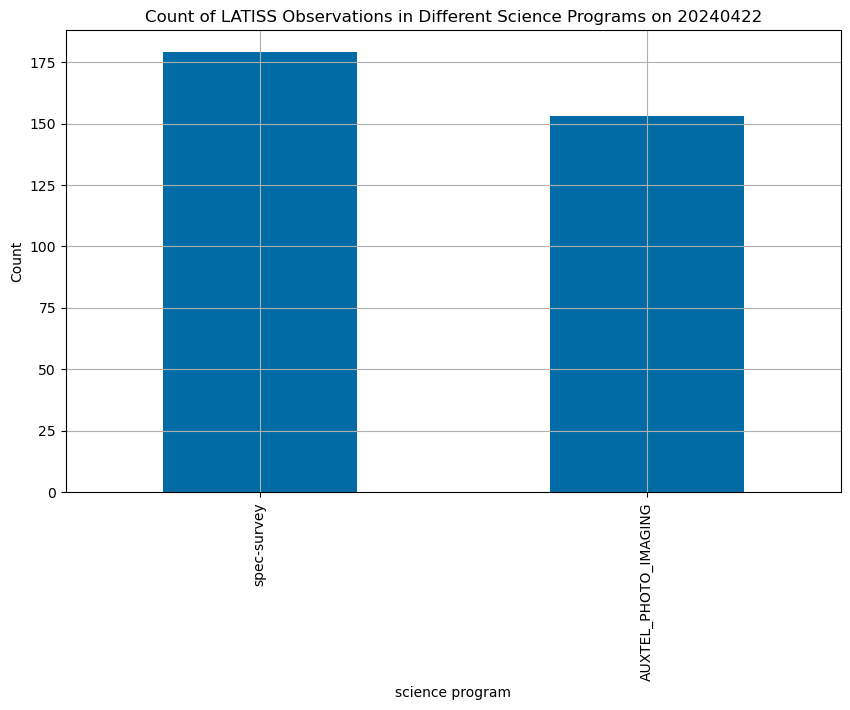

In [18]:
plt.figure(figsize=(10, 6))

# Count the occurrences of each unique value in col1
value_counts = df_science['science_program'].value_counts()

# Create the bar plot
value_counts.plot(kind='bar')

# Add labels and title
plt.xlabel('science program')
plt.ylabel('Count')
title = """Count of %s Observations in Different Science Programs on %s""" %(instrument, day_obs)
plt.title(title)
plt.grid(True)


Now, let's look at the counts of exposures for the different targets observed on this date.

In [19]:
df_science.groupby("target").count()["id"]

target
HD111235           70
HD144334           74
HD185975           20
HD38666            15
Photo0800-1_001     4
Photo0800-1_002     4
Photo0800-1_003     4
Photo0800-1_004     4
Photo0800-1_005     4
Photo0800-1_006     4
Photo0800-1_007     4
Photo0800-1_008     4
Photo0800-1_009     4
Photo0800-1_010     4
Photo0800-1_011     4
Photo0800-1_012     4
Photo0800-1_013     4
Photo0800-1_014     4
Photo0800-1_015     4
Photo0800-1_016     4
Photo0800-1_017     4
Photo0800-1_018     4
Photo0800-1_019     4
Photo0800-1_020     4
Photo0800-1_021     4
Photo0800-1_022     4
Photo0800-1_023     4
Photo0800-1_024     4
Photo1600-1_018     4
Photo1600-1_019     4
Photo1600-1_020     4
Photo1600-1_021     4
Photo1600-1_022     4
Photo1600-1_023     4
Photo1600-1_024     4
Photo1600-1_025     4
Photo1600-1_026     4
Photo1600-1_027     4
Photo1600-1_028     4
Photo1600-1_029     4
Photo1600-1_030     4
Photo1600-1_031     4
Photo1600-1_032     1
Name: id, dtype: int64

Let's plot this as a 1D histogram.

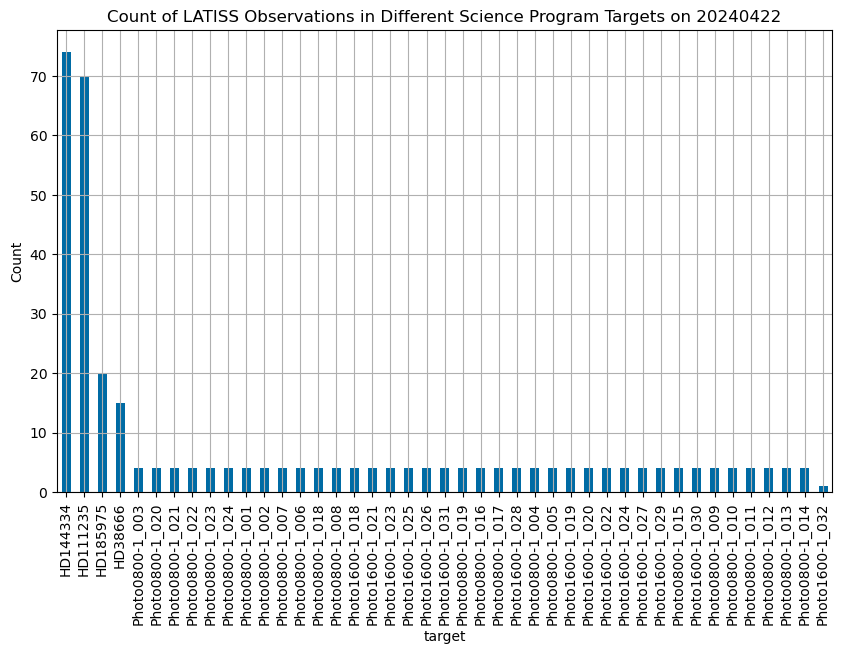

In [20]:
plt.figure(figsize=(10, 6))

# Count the occurrences of each unique value in col1
value_counts = df_science['target'].value_counts()

# Create the bar plot
value_counts.plot(kind='bar')

# Add labels and title
plt.xlabel('target')
plt.ylabel('Count')
title = """Count of %s Observations in Different Science Program Targets on %s""" %(instrument, day_obs)
plt.title(title)
plt.grid(True)


Let's organize these counts by both **science program** and **target**...

In [21]:
df_science.groupby(["science_program","target"]).count()["id"]

science_program       target         
AUXTEL_PHOTO_IMAGING  Photo0800-1_001     4
                      Photo0800-1_002     4
                      Photo0800-1_003     4
                      Photo0800-1_004     4
                      Photo0800-1_005     4
                      Photo0800-1_006     4
                      Photo0800-1_007     4
                      Photo0800-1_008     4
                      Photo0800-1_009     4
                      Photo0800-1_010     4
                      Photo0800-1_011     4
                      Photo0800-1_012     4
                      Photo0800-1_013     4
                      Photo0800-1_014     4
                      Photo0800-1_015     4
                      Photo0800-1_016     4
                      Photo0800-1_017     4
                      Photo0800-1_018     4
                      Photo0800-1_019     4
                      Photo0800-1_020     4
                      Photo0800-1_021     4
                      Photo0800-1_022 

Here's a 2D histogram plot of the same...

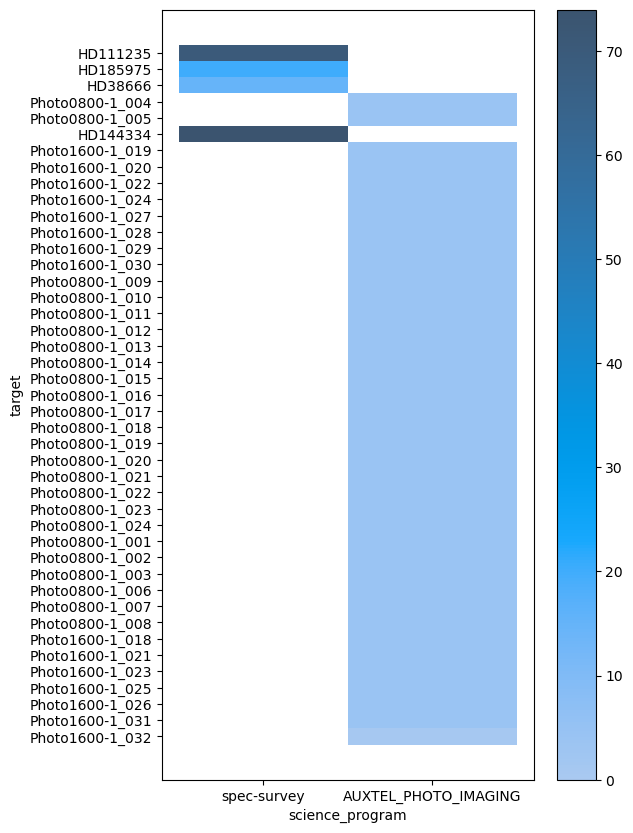

In [22]:
plt.figure(figsize=(6, 10))
ax = sns.histplot(data=df_science, x="science_program", y="target", cbar=True)

Now let's organize these counts by **target** and **filter**...  (Note: we need to reset the pandas `display.max_rows` option to see the full table.)

In [23]:
# Change the display.max_rows option
pd.set_option("display.max_rows", None)

# Run groupby command
print(df_science.groupby(["target","filter"]).count()["id"])

# Reset the display.max_rows option to the original default
pd.reset_option("display.max_rows")


target           filter               
HD111235         empty~blue300lpmm_qn1    42
                 empty~holo4_003          28
HD144334         empty~blue300lpmm_qn1    44
                 empty~holo4_003          30
HD185975         empty~blue300lpmm_qn1    12
                 empty~holo4_003           8
HD38666          empty~blue300lpmm_qn1     9
                 empty~holo4_003           6
Photo0800-1_001  SDSSg_65mm~empty          1
                 SDSSr_65mm~empty          1
                 SDSSz_65mm~empty          1
                 empty~SDSSy_65mm          1
Photo0800-1_002  SDSSg_65mm~empty          1
                 SDSSr_65mm~empty          1
                 SDSSz_65mm~empty          1
                 empty~SDSSy_65mm          1
Photo0800-1_003  SDSSg_65mm~empty          1
                 SDSSr_65mm~empty          1
                 SDSSz_65mm~empty          1
                 empty~SDSSy_65mm          1
Photo0800-1_004  SDSSg_65mm~empty          1
                

Here's a 2D histogram plot of the same...

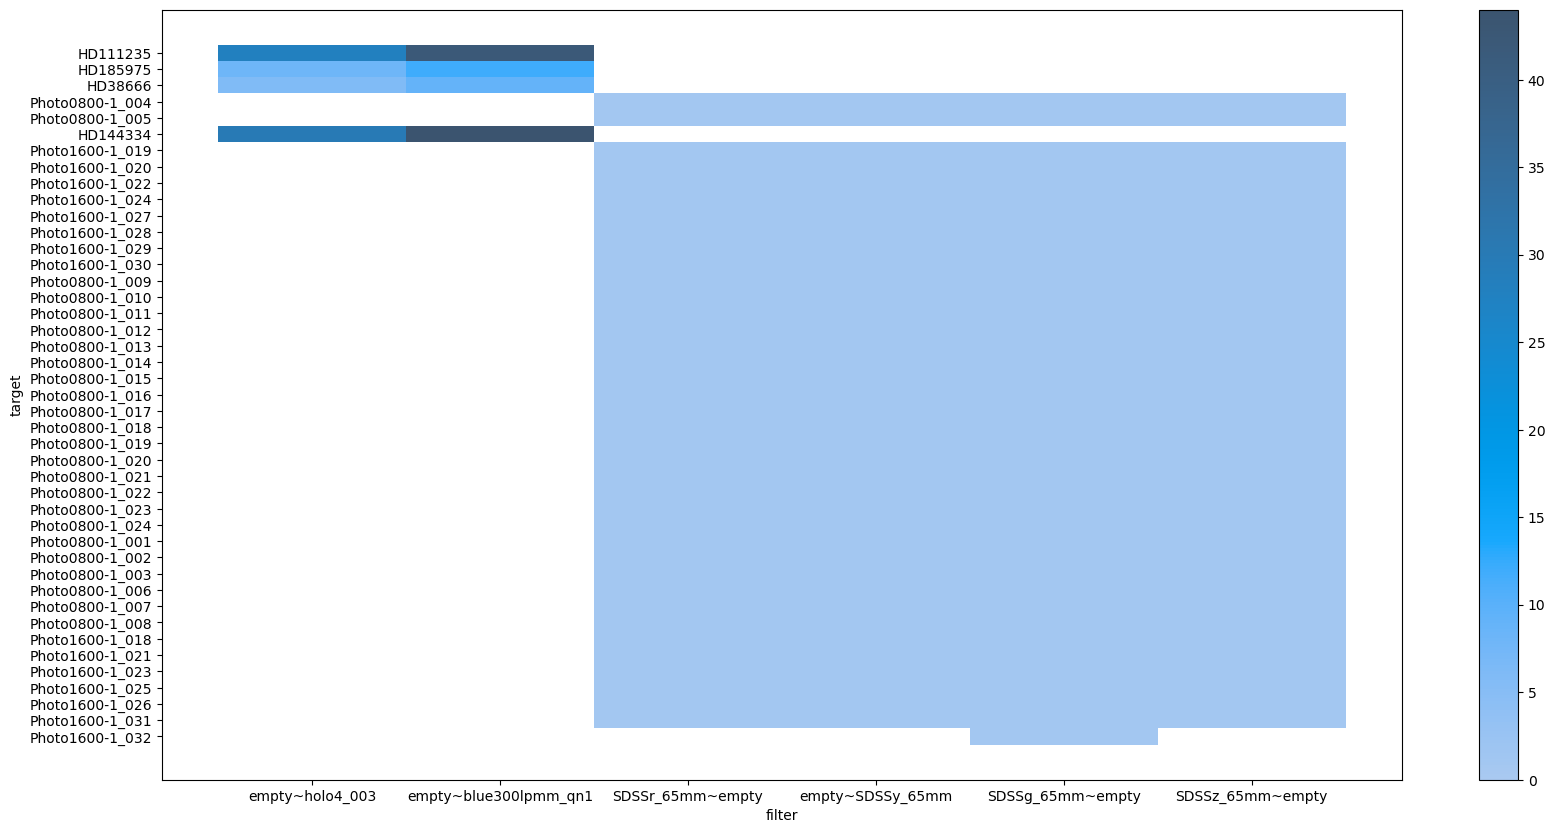

In [24]:
plt.figure(figsize=(20, 10))
ax = sns.histplot(data=df_science, x="filter", y="target", cbar=True)

Next, let's organize the counts by three variables: **science program**, **target**, and **filter**...  (Note: as before, we need to reset the pandas `display.max_rows` option to see the full table.)

In [25]:
# Change the display.max_rows option
pd.set_option("display.max_rows", None)

# Run groupby command
print(df_science.groupby(["science_program","target","filter"]).count()["id"])

# Reset the display.max_rows option to the original default
pd.reset_option("display.max_rows")


science_program       target           filter               
AUXTEL_PHOTO_IMAGING  Photo0800-1_001  SDSSg_65mm~empty          1
                                       SDSSr_65mm~empty          1
                                       SDSSz_65mm~empty          1
                                       empty~SDSSy_65mm          1
                      Photo0800-1_002  SDSSg_65mm~empty          1
                                       SDSSr_65mm~empty          1
                                       SDSSz_65mm~empty          1
                                       empty~SDSSy_65mm          1
                      Photo0800-1_003  SDSSg_65mm~empty          1
                                       SDSSr_65mm~empty          1
                                       SDSSz_65mm~empty          1
                                       empty~SDSSy_65mm          1
                      Photo0800-1_004  SDSSg_65mm~empty          1
                                       SDSSr_65mm~empty          1
 

### 3.2 Positions

Plot RA, DEC...

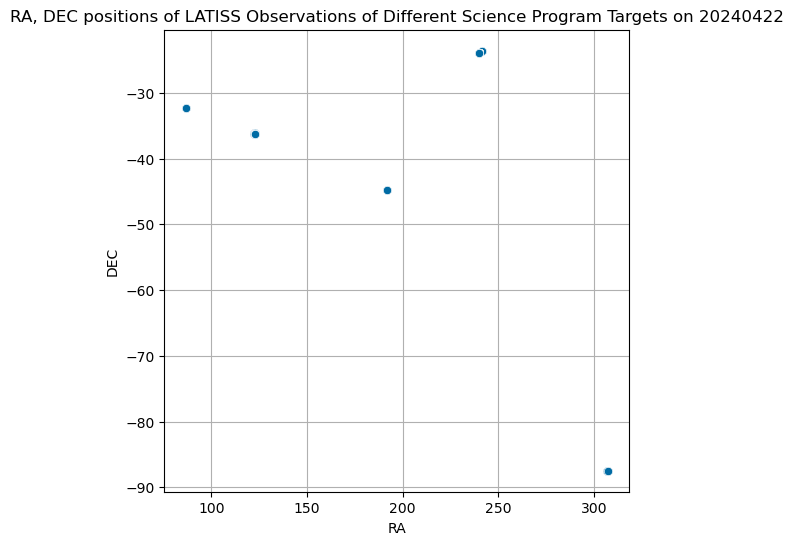

In [49]:
plt.figure(figsize=(6, 6))

# Plot in Cartesian coordinates
#df_science.plot('ra','dec', kind='scatter')
ax = sns.scatterplot(data=df_science, x="ra", y="dec")

# Add labels and title
plt.xlabel('RA')
plt.ylabel('DEC')
title = """RA, DEC positions of %s Observations of Different Science Program Targets on %s""" %(instrument, day_obs)
plt.title(title)
plt.grid(True)


Plot target vs. zenith_angle

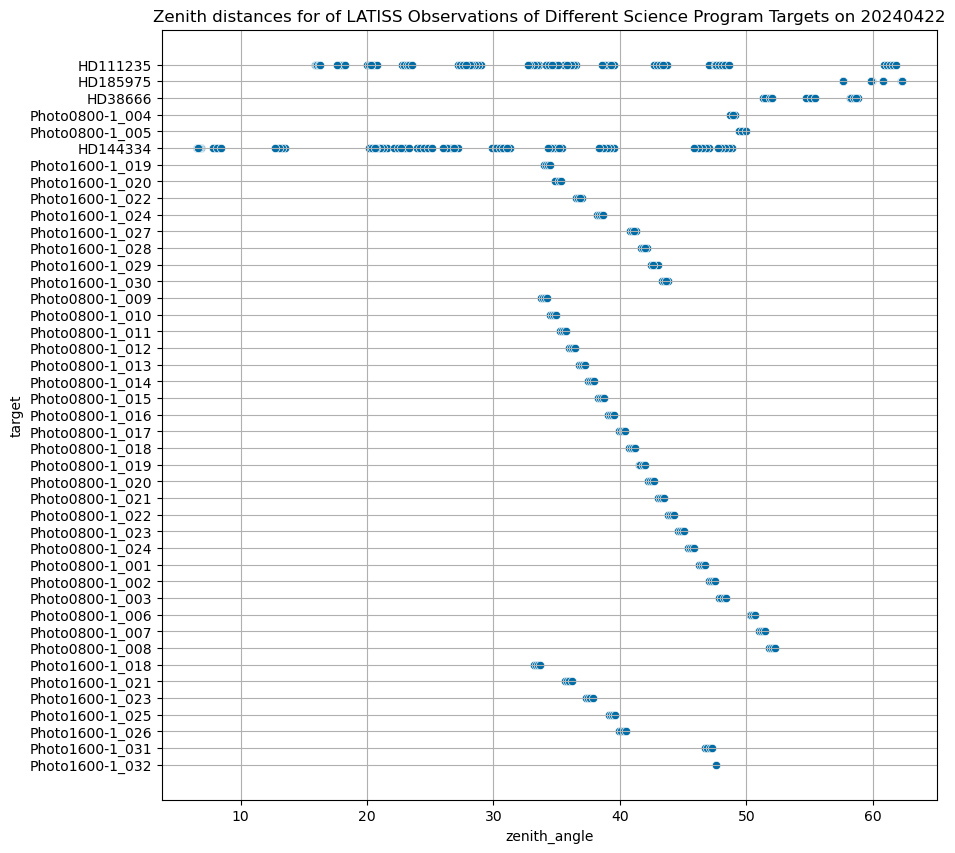

In [52]:
plt.figure(figsize=(10, 10))

ax = sns.scatterplot(data=df_science, x="zenith_angle", y="target")

# Add labels and title
#plt.xlabel('Zenith Angle')
#plt.ylabel('Target')
title = """Zenith distances for of %s Observations of Different Science Program Targets on %s""" %(instrument, day_obs)
plt.title(title)
plt.grid(True)


Plot target vs. MJD...

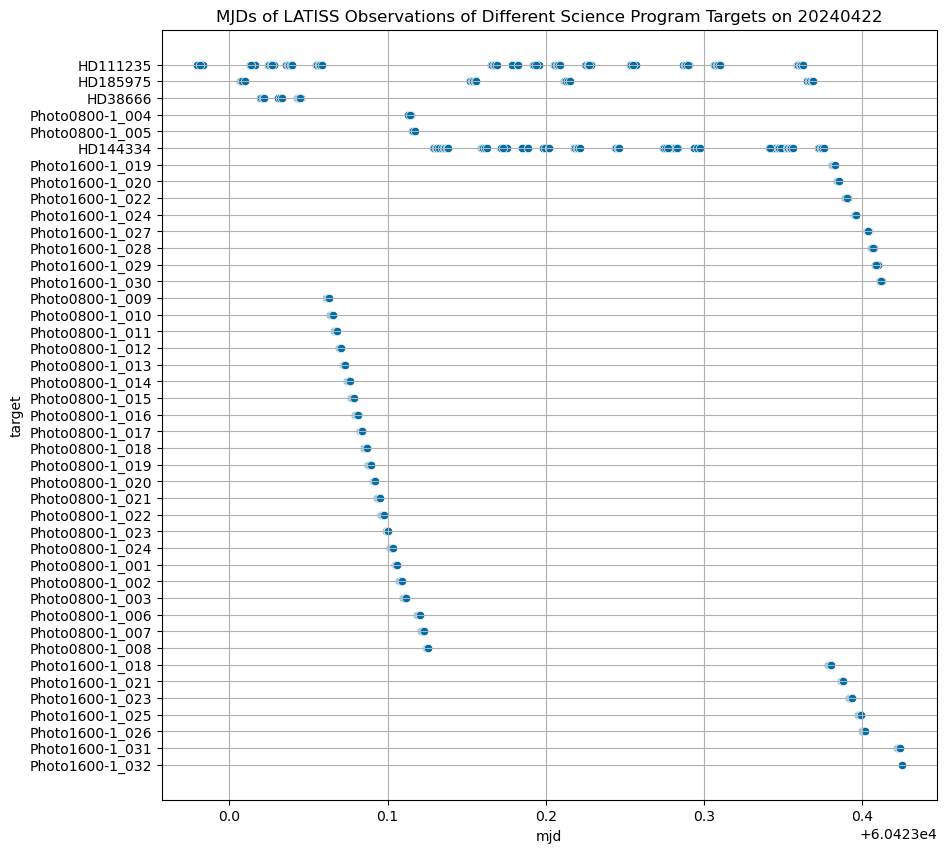

In [53]:
plt.figure(figsize=(10, 10))

ax = sns.scatterplot(data=df_science, x="mjd", y="target")

# Add labels and title
#plt.xlabel('Zenith Angle')
#plt.ylabel('Target')
title = """MJDs of %s Observations of Different Science Program Targets on %s""" %(instrument, day_obs)
plt.title(title)
plt.grid(True)


## Sandbox